In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import pywt
from skimage.filters import sobel_h, sobel_v
import glob

def extract_features(df, img_root_col="img_path"):
    feats = []
    for idx, row in df.iterrows():
        path = row[img_root_col]
        if not os.path.isfile(path):
            # skip missing
            continue

        # --- load and gray-scale ---
        img = Image.open(path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0

        # --- 1) spatial residual stats (for LSB) ---
        #   compute horizontal & vertical Sobel residuals
        rx = sobel_h(arr)
        ry = sobel_v(arr)
        res = np.stack([rx, ry], axis=0)
        # summary stats: mean & var of each residual band
        stat_spatial = []
        for band in res:
            stat_spatial += [band.mean(), band.var()]

        # --- 2) wavelet subband energies (for IWT) ---
        # 2-level Haar DWT
        coeffs = pywt.wavedec2(arr, wavelet='haar', level=2)
        # coeffs = [cA2, (cH2,cV2,cD2), (cH1,cV1,cD1)]
        stat_wave = []
        # skip the final approximation (cA2), focus on detail bands
        for level in coeffs[1:]:
            for subband in level:
                stat_wave.append(np.sum(subband**2) / subband.size)

        # --- assemble ---
        feature_vector = stat_spatial + stat_wave
        feats.append({
            "idx": idx,
            **{f"f{i}": v for i, v in enumerate(feature_vector)},
            "label": row["label"]
        })

    feat_df = pd.DataFrame(feats).set_index("idx")
    return feat_df


In [8]:
# ——— build your DataFrame ———
STEGO_CSV = "./csv/stego_final.csv"
df = pd.read_csv(STEGO_CSV)
df = df[df.method.isin(["lsb","iwt"])].copy()
df["label"]    = df["method"]
df["img_path"] = df["stego_path"]

# cover images from folder
cover_paths = glob.glob(os.path.join("./initial", "*.*"))  # adjust pattern if needed
cover_df = pd.DataFrame({"img_path": cover_paths})
cover_df["label"] = "none"

# full dataset
full_df = pd.concat([df[["img_path","label"]], cover_df], ignore_index=True)

# extract features
feat_df = extract_features(full_df)
print(feat_df.shape)
feat_df.head()

(3897, 11)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,label
idx,,,,,,,,,,,
0,-0.001066,0.003528,-0.001223,0.003756,0.010723,0.010088,0.001403,0.001453,0.001587,0.000087,lsb
1,-0.000023,0.023723,-0.000202,0.018495,0.053284,0.038068,0.018195,0.014879,0.012256,0.004988,lsb
2,0.001033,0.009781,0.000423,0.009553,0.024196,0.024039,0.006649,0.005074,0.004710,0.001067,lsb
3,0.000268,0.014513,-0.000260,0.014876,0.035603,0.037020,0.008028,0.007574,0.007590,0.001265,lsb
4,-0.000143,0.020455,0.000291,0.024225,0.039782,0.047584,0.024700,0.013742,0.016766,0.007745,lsb


Stage 1 ROC AUC: 0.5044
Chosen probability threshold for ≥98% recall: 0.481
At chosen threshold:
  Accuracy : 0.4910
  Precision: 0.4889
  Recall   : 0.9816


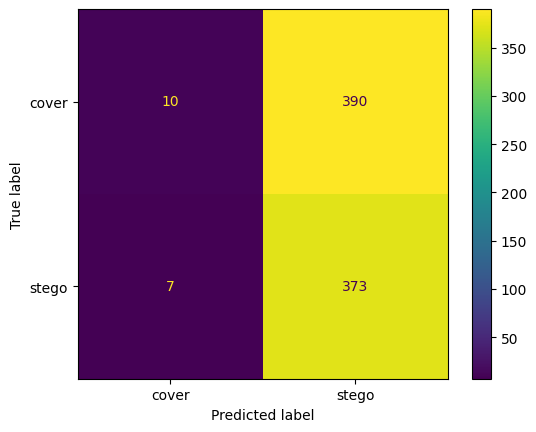

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
)

# ——— 1) Prepare the labels ———
# assume `feat_df` is your DataFrame with f0–f9 and original "label"
feat_df["stage1_label"] = feat_df["label"].isin(["lsb", "iwt"]).astype(int)

# feature matrix & target vector
X = feat_df[[f"f{i}" for i in range(10)]].values
y = feat_df["stage1_label"].values

# ——— 2) Stratified train/test split ———
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ——— 3) Train a baseline model ———
# you can swap in RandomForestClassifier(...) if you prefer
clf = LogisticRegression(max_iter=1_000, random_state=42)
clf.fit(X_train, y_train)

# ——— 4) Get predicted probabilities & ROC AUC ———
y_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Stage 1 ROC AUC: {roc_auc:.4f}")

# ——— 5) Precision–Recall curve & threshold tuning ———
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# pick the highest threshold that still gives ≥98% recall
desired_recall = 0.98
# recall[0] corresponds to threshold=1.0; thresholds array is one shorter than recall
idxs = np.where(recall[:-1] >= desired_recall)[0]
if len(idxs) > 0:
    thresh = thresholds[idxs[-1]]
else:
    thresh = 0.5  # fallback
print(f"Chosen probability threshold for ≥{desired_recall*100:.0f}% recall: {thresh:.3f}")

# ——— 6) Evaluate at this threshold ———
y_pred = (y_proba >= thresh).astype(int)
print("At chosen threshold:")
print(f"  Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall   : {recall_score(y_test, y_pred):.4f}")

# ——— 7) (Optional) Inspect the confusion matrix ———
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["cover","stego"])


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    accuracy_score, precision_score, recall_score
)

# 1) Prepare features & labels
X = feat_df[[f"f{i}" for i in range(10)]].values
y_stage1 = feat_df["label"].isin(["lsb","iwt"]).astype(int).values  # 1=stego, 0=cover
y_orig   = feat_df["label"].values                                  # "none","lsb","iwt"

# 2) Stratified train/test split (keep y_orig for Stage 2)
X_train, X_test, y1_train, y1_test, y_orig_train, y_orig_test = train_test_split(
    X, y_stage1, y_orig,
    test_size=0.2,
    stratify=y_stage1,
    random_state=42
)

# 3) Train Stage 1: Stego vs Cover
clf1 = LogisticRegression(max_iter=1_000, random_state=42)
clf1.fit(X_train, y1_train)
proba1_test = clf1.predict_proba(X_test)[:,1]

# 4) Pick threshold for ≥98% recall on stego
prec, rec, th = precision_recall_curve(y1_test, proba1_test)
idx = np.where(rec[:-1] >= 0.98)[0]
thr = th[idx[-1]] if len(idx)>0 else 0.5
print(f"Stage 1 threshold for ≥98% recall: {thr:.3f}")

# 5) Mask out test/train stego sets
mask1_train = clf1.predict_proba(X_train)[:,1] >= thr  # boolean mask on X_train
mask1_test  = proba1_test                     >= thr  # boolean mask on X_test

# 6) Build Stage 2 training data (only stego)
X2_train = X_train[mask1_train]
y2_train = np.where(y_orig_train[mask1_train]=="lsb", 0, 1)  # 0=LSB, 1=IWT

# 7) Train Stage 2 with class balancing
clf2 = LogisticRegression(
    class_weight="balanced",
    max_iter=2_000,
    random_state=42
)
clf2.fit(X2_train, y2_train)

# 8) Evaluate Stage 2 on its own filtered test set
X2_test = X_test[mask1_test]
y2_test = np.where(y_orig_test[mask1_test]=="lsb", 0, 1)
y2_pred = clf2.predict(X2_test)

print("\n--- Stage 2 (LSB vs IWT) ---")
print(classification_report(y2_test, y2_pred, target_names=["lsb","iwt"]))

# 9) End-to-end: build final_pred over the full X_test
final_pred = []
for i in range(len(X_test)):
    if not mask1_test[i]:
        final_pred.append("none")   # Stage 1 said "cover"
    else:
        p2 = clf2.predict(X_test[i].reshape(1,-1))[0]
        final_pred.append("lsb" if p2==0 else "iwt")

# 10) Compare against y_orig_test
print("\n--- End-to-end classification (none/lsb/iwt) ---")
print(classification_report(y_orig_test, final_pred, labels=["none","lsb","iwt"]))

cm = confusion_matrix(y_orig_test, final_pred, labels=["none","lsb","iwt"])
cm_df = pd.DataFrame(
    cm,
    index=["true_none","true_lsb","true_iwt"],
    columns=["pred_none","pred_lsb","pred_iwt"]
)
print(cm_df)


Stage 1 threshold for ≥98% recall: 0.481

--- Stage 2 (LSB vs IWT) ---
              precision    recall  f1-score   support

         lsb       0.25      1.00      0.40       189
         iwt       0.00      0.00      0.00       574

    accuracy                           0.25       763
   macro avg       0.12      0.50      0.20       763
weighted avg       0.06      0.25      0.10       763


--- End-to-end classification (none/lsb/iwt) ---
              precision    recall  f1-score   support

        none       0.59      0.03      0.05       400
         lsb       0.25      0.97      0.39       194
         iwt       0.00      0.00      0.00       186

    accuracy                           0.26       780
   macro avg       0.28      0.33      0.15       780
weighted avg       0.36      0.26      0.12       780

           pred_none  pred_lsb  pred_iwt
true_none         10       390         0
true_lsb           5       189         0
true_iwt           2       184         0


/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils import resample

# ——— 1) Prepare features & labels ———
X = feat_df[[f"f{i}" for i in range(10)]].values
y_stage1 = feat_df["label"].isin(["lsb","iwt"]).astype(int).values  # 1=stego, 0=cover
y_orig   = feat_df["label"].values                                  # "none","lsb","iwt"

# ——— 2) Train/test split ———
X_train, X_test, y1_train, y1_test, y_orig_train, y_orig_test = train_test_split(
    X, y_stage1, y_orig,
    test_size=0.2,
    stratify=y_stage1,
    random_state=42
)

# ——— 3) Train Stage 1 classifier ———
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf1.fit(X_train, y1_train)
proba1_test = clf1.predict_proba(X_test)[:,1]

# ——— 4) Compute precision–recall curve ———
prec, rec, th = precision_recall_curve(y1_test, proba1_test)

# ——— 5) Define recall targets & find thresholds ———
recall_targets = [0.90, 0.95, 0.98]
thresholds = []
for tgt in recall_targets:
    idxs = np.where(rec[:-1] >= tgt)[0]
    if len(idxs):
        thresholds.append(th[idxs[-1]])
    else:
        thresholds.append(0.5)

# ——— 6) Loop over thresholds & evaluate Stage 2 under each ———
for thr in thresholds:
    # 6a) Mask out stego for train & test
    mask_train = clf1.predict_proba(X_train)[:,1] >= thr
    mask_test  = proba1_test                    >= thr

    print(f"\n=== Stage 1 threshold: {thr:.3f} ===")
    print(f" forwarded to Stage 2 → train: {mask_train.sum()}, test: {mask_test.sum()}")

    # 6b) Build Stage 2 datasets
    X2_train = X_train[mask_train]
    y2_train = np.where(y_orig_train[mask_train]=="lsb", 0, 1)  # 0=LSB,1=IWT
    X2_test  = X_test[mask_test]
    y2_test  = np.where(y_orig_test[mask_test]=="lsb", 0, 1)

    # 6c) Oversample minority class for logistic regression
    maj = 0 if (y2_train==0).sum() > (y2_train==1).sum() else 1
    min_ = 1-maj
    X_min = X2_train[y2_train==min_]
    y_min = y2_train[y2_train==min_]
    X_ups, y_ups = resample(
        X_min, y_min,
        replace=True,
        n_samples=(y2_train==maj).sum(),
        random_state=42
    )
    X2_bal = np.vstack([X2_train[y2_train==maj], X_ups])
    y2_bal = np.concatenate([y2_train[y2_train==maj], y_ups])

    # 6d) Train & evaluate oversampled Logistic Regression
    clf_log = LogisticRegression(max_iter=1000, random_state=42)
    clf_log.fit(X2_bal, y2_bal)
    y2_pred_log = clf_log.predict(X2_test)
    print("\n LogisticRegression (oversampled minority):")
    print(classification_report(y2_test, y2_pred_log, target_names=["lsb","iwt"]))

    # 6e) Train & evaluate RandomForest with balanced class weights
    clf_rf = RandomForestClassifier(
        class_weight="balanced",
        n_estimators=100,
        random_state=42
    )
    clf_rf.fit(X2_train, y2_train)
    y2_pred_rf = clf_rf.predict(X2_test)
    print("\n RandomForestClassifier (class_weight='balanced'):")
    print(classification_report(y2_test, y2_pred_rf, target_names=["lsb","iwt"]))



=== Stage 1 threshold: 0.483 ===
 forwarded to Stage 2 → train: 2845, test: 699

 LogisticRegression (oversampled minority):
              precision    recall  f1-score   support

         lsb       0.25      1.00      0.40       174
         iwt       0.00      0.00      0.00       525

    accuracy                           0.25       699
   macro avg       0.12      0.50      0.20       699
weighted avg       0.06      0.25      0.10       699



/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 RandomForestClassifier (class_weight='balanced'):
              precision    recall  f1-score   support

         lsb       0.18      0.28      0.22       174
         iwt       0.70      0.57      0.63       525

    accuracy                           0.49       699
   macro avg       0.44      0.42      0.42       699
weighted avg       0.57      0.49      0.53       699


=== Stage 1 threshold: 0.482 ===
 forwarded to Stage 2 → train: 2968, test: 731

 LogisticRegression (oversampled minority):
              precision    recall  f1-score   support

         lsb       0.25      0.57      0.35       183
         iwt       0.75      0.44      0.56       548

    accuracy                           0.47       731
   macro avg       0.50      0.50      0.45       731
weighted avg       0.63      0.47      0.50       731


 RandomForestClassifier (class_weight='balanced'):
              precision    recall  f1-score   support

         lsb       0.17      0.26      0.21       183
       

/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 RandomForestClassifier (class_weight='balanced'):
              precision    recall  f1-score   support

         lsb       0.16      0.25      0.20       189
         iwt       0.70      0.59      0.64       574

    accuracy                           0.50       763
   macro avg       0.43      0.42      0.42       763
weighted avg       0.57      0.50      0.53       763



In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils import resample

# ——— 0) Prepare features & labels ———
X = feat_df[[f"f{i}" for i in range(10)]].values
y_stage1 = feat_df["label"].isin(["lsb","iwt"]).astype(int).values  # 1=stego, 0=cover
y_orig   = feat_df["label"].values                                  # "none","lsb","iwt"

# ——— 1) Split once ———
X_train, X_test, y1_train, y1_test, y_orig_train, y_orig_test = train_test_split(
    X, y_stage1, y_orig,
    test_size=0.2, stratify=y_stage1, random_state=42
)

# ——— 2) Fit Stage 1 model ———
stage1 = LogisticRegression(max_iter=1000, random_state=42)
stage1.fit(X_train, y1_train)
proba1_test = stage1.predict_proba(X_test)[:,1]

# ——— 3) Find thresholds for desired recall targets ———
prec, rec, th = precision_recall_curve(y1_test, proba1_test)
recall_targets = [0.90, 0.95, 0.98]
thresholds = []
for tgt in recall_targets:
    idxs = np.where(rec[:-1] >= tgt)[0]
    thresholds.append(th[idxs[-1]] if len(idxs) else 0.5)

# ——— 4) Evaluate end-to-end over thresholds & Stage 2 models ———
results = []
for thr in thresholds:
    # masks
    mask_train = stage1.predict_proba(X_train)[:,1] >= thr
    mask_test  = proba1_test                   >= thr

    # build Stage2 train/test
    X2_train = X_train[mask_train]
    y2_train = np.where(y_orig_train[mask_train]=="lsb", 0, 1)  # 0=LSB,1=IWT
    X2_test  = X_test[mask_test]
    y2_test  = np.where(y_orig_test[mask_test]=="lsb", 0, 1)

    # 4a) Oversampled Logistic Regression
    #   balance minority by up-sampling
    maj = 0 if (y2_train==0).sum() > (y2_train==1).sum() else 1
    min_ = 1 - maj
    X_min = X2_train[y2_train==min_]
    y_min = y2_train[y2_train==min_]
    X_up, y_up = resample(X_min, y_min,
                         replace=True,
                         n_samples=(y2_train==maj).sum(),
                         random_state=42)
    X2_bal = np.vstack([X2_train[y2_train==maj], X_up])
    y2_bal = np.concatenate([y2_train[y2_train==maj], y_up])

    clf_log = LogisticRegression(max_iter=1000, random_state=42)
    clf_log.fit(X2_bal, y2_bal)

    # 4b) RandomForest with built-in class balancing
    clf_rf = RandomForestClassifier(
        class_weight="balanced",
        n_estimators=100,
        random_state=42
    )
    clf_rf.fit(X2_train, y2_train)

    # helper to run end-to-end
    def eval_e2e(model, name):
        preds = []
        for i in range(len(X_test)):
            if not mask_test[i]:
                preds.append("none")
            else:
                p2 = model.predict(X_test[i].reshape(1,-1))[0]
                preds.append("lsb" if p2==0 else "iwt")
        return {
            "threshold": thr,
            "stage2_model": name,
            "accuracy": accuracy_score(y_orig_test, preds),
            "macro_precision": precision_score(y_orig_test, preds, average="macro", zero_division=0),
            "macro_recall":    recall_score   (y_orig_test, preds, average="macro"),
            "macro_f1":        f1_score       (y_orig_test, preds, average="macro"),
        }

    results.append(eval_e2e(clf_log, "logistic_oversampled"))
    results.append(eval_e2e(clf_rf,  "random_forest"))

# ——— 5) Show summary ———
res_df = pd.DataFrame(results)
print(res_df.sort_values(by="macro_f1", ascending=False).to_string(index=False))


 threshold         stage2_model  accuracy  macro_precision  macro_recall  macro_f1
  0.483406        random_forest  0.292308         0.343345      0.363753  0.278077
  0.482047 logistic_oversampled  0.273077         0.370720      0.345271  0.263228
  0.482047        random_forest  0.284615         0.367624      0.365539  0.262667
  0.481232        random_forest  0.265385         0.355652      0.357907  0.232004
  0.483406 logistic_oversampled  0.278205         0.259930      0.334802  0.189497
  0.481232 logistic_oversampled  0.255128         0.278647      0.333076  0.147649
